# Model Interpretation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Importance</a></span><ul class="toc-item"><li><span><a href="#PredictionValuesChange" data-toc-modified-id="PredictionValuesChange-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>PredictionValuesChange</a></span></li><li><span><a href="#Shap-Values" data-toc-modified-id="Shap-Values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Shap Values</a></span></li><li><span><a href="#Interaction-Feature-Importance" data-toc-modified-id="Interaction-Feature-Importance-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Interaction Feature Importance</a></span></li></ul></li></ul></div>

In [17]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import shap
from catboost import CatBoostClassifier

In [18]:
from catboost import Pool

In [19]:
os.getcwd()

'/Users/mac/Documents/Python/CreditRisk'

In [20]:
os.chdir('/Users/mac/Documents/Python/CreditRisk')

In [21]:
df_val = pd.read_csv('Data/df_val_clean.csv')

In [22]:
df_val.shape

(6515, 12)

In [23]:
X_validation = df_val.copy()
y_validation = X_validation.pop('loan_status')

In [24]:
def feature_engineering(X):
    X_new = X.copy()
        
    X_new.drop('cb_person_cred_hist_length',axis=1,inplace=True)
    
    #person employed
    X_new.loc[X_new.person_emp_length==0,'employed'] = 'N'
    X_new.loc[X_new.person_emp_length >0,'employed'] = 'Y'
    
    #income médio por tipo de home ownership
    by_home_ownership = X_new.groupby('person_home_ownership')
    X_new['mean_income_homeown'] = by_home_ownership.person_income.transform(lambda x: x.mean()).round(2)

    #loan_intent
    by_loan_intent = X_new.groupby('loan_intent')
    X_new['mean_income_intent'] = by_loan_intent.person_income.transform(lambda x: x.mean()).round(2)

    #income médio por loan_grade
    by_loan_grade = X_new.groupby('loan_grade')
    X_new['mean_income_grade'] = by_loan_grade.person_income.transform(lambda x: x.mean()).round(2)

    #person_income/person_emp_lengthD
    X_new.loc[X_new.person_emp_length==0,'income_emp_length_ratio'] = 0
    X_new.loc[X_new.person_emp_length!=0,'income_emp_length_ratio'] = X_new.person_income / X_new.person_emp_length

    #Difference between person_income and loan_amnt
    X_new['income_loan_diff'] = X_new['person_income'] - X_new['loan_amnt']

    return X_new

In [25]:
X_validation = feature_engineering(X_validation)

In [26]:
model = CatBoostClassifier()

model.load_model("Models/catboost_model_1.bin")

In [27]:
cat_features = [col for col in X_validation.select_dtypes(['object'])]

In [28]:
validation_pool = Pool(X_validation,y_validation,cat_features=cat_features)

## Feature Importance

### PredictionValuesChange

For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value if this feature is changed.

The output is normalized, all the importances will add up to 100

In [29]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,loan_percent_income,29.001890
1,mean_income_homeown,16.161473
2,loan_grade,12.743794
3,person_income,9.209486
4,person_home_ownership,7.801767
5,loan_intent,6.456856
6,person_emp_length,4.359186
7,mean_income_grade,4.255753
8,mean_income_intent,3.576818
9,income_loan_diff,2.142758


- The **most infomartive** features are:
    - **loan_percent_income**: this feature already had a high MI score.
    - **person_home_ownership**: also showed a considerable MI score, but not in the highest values, maybe this variable have interactions with others captured by the model. 
- The **lest informative features** are:
    - **mean_income_grade**: small MI score. 
    - **cb_person_default_on_file**: small MI score.

### Shap Values

SHAP value breaks a prediction value into contributions from each feature.

In [30]:
shap_values = model.get_feature_importance(validation_pool,type='ShapValues')

In [31]:
expected_values = shap_values[0,-1]
shap_values=shap_values[:,:-1]

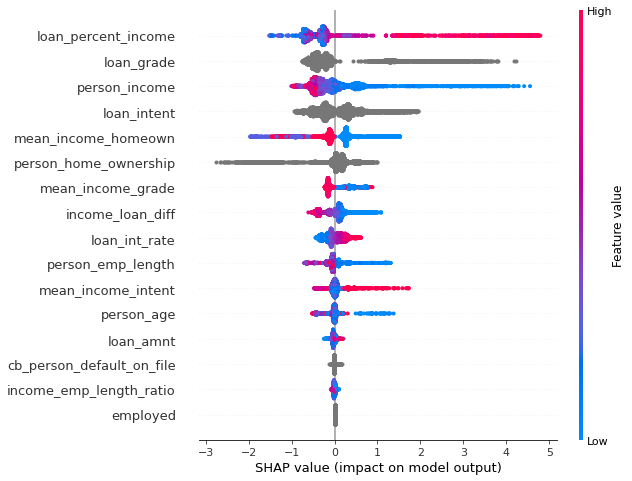

In [32]:
shap.summary_plot(shap_values,X_validation)

In [33]:
y_pred = pd.concat([y_validation,pd.Series(model.predict_proba(X_validation)[:,1],name='p_1')],axis=1)

In [34]:
#Observacao com maior probabilidade de default
y_pred.loc[y_pred['p_1']==y_pred['p_1'].max()]

,loan_status,p_1
2566,1,0.999971


In [35]:
shap.initjs()
shap.force_plot(expected_values, shap_values[985,:], X_validation.iloc[985,:])

In [36]:
#Observacao com menor probabilidade de Default
y_pred.loc[y_pred['p_1']==y_pred['p_1'].min()]

,loan_status,p_1
831,0,0.000413


In [37]:
shap.initjs()
shap.force_plot(expected_values, shap_values[634,:], X_validation.iloc[634,:])

In [38]:
shap.initjs()
shap.force_plot(expected_values, shap_values[2,:], X_validation.iloc[2,:])

In [39]:
y_pred.loc[(y_pred['p_1']>=0.5) & (y_pred['p_1']<0.6)].sample(1)

,loan_status,p_1
4036,1,0.52895


In [40]:
shap.initjs()
shap.force_plot(expected_values, shap_values[2710,:], X_validation.iloc[2710,:])

In [41]:
y_pred.loc[(y_pred['p_1']>=0.5) & (y_pred['p_1']<0.6)].sample(1)

,loan_status,p_1
4036,1,0.52895


In [42]:
shap.initjs()
shap.force_plot(expected_values, shap_values[1694,:], X_validation.iloc[1694,:])

### Interaction Feature Importance

With this parameter, you can find the strength of a pair of features (importance of two features together).

In [43]:
fi = model.get_feature_importance(Pool(X_validation, label=y_validation,cat_features=cat_features), 
                                                                     type="Interaction")

In [44]:
fi_new = []
for k,item in enumerate(fi):  
    first = X_validation.dtypes.index[fi[k][0]]
    second = X_validation.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + "_" + second, fi[k][2]])

/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  after removing the cwd from sys.path.


In [45]:
fi_new[:5]

[['loan_intent_loan_grade', 5.6839225137696525],
 ['person_home_ownership_loan_grade', 5.388361480227961],
 ['loan_grade_loan_percent_income', 4.2616847030564395],
 ['person_income_loan_percent_income', 3.883393364028051],
 ['person_income_loan_grade', 3.8573086922876936]]

In [46]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])

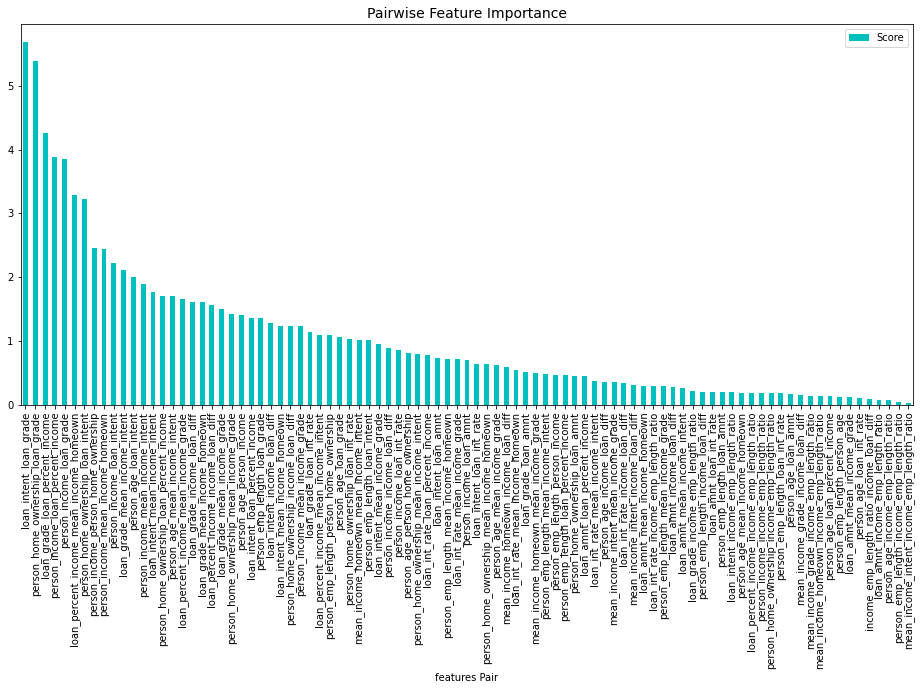

In [47]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort',
                                          na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()